In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Model, layers, models, optimizers, losses

2023-02-02 19:52:54.845341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 19:52:54.929369: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-02 19:52:54.929386: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-02 19:52:55.537987: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Reading the datasets

- dataset or HMF_theor.csv refers to the theoretical values obtained by a calculator assuming spheric colapse and LCDM.
- lcdm or lcdm_counts.dat contain data points from simulation assuming LCDM.

In [2]:
dataset_calc = pd.read_csv('data/HMF_theor.csv').drop(['Unnamed: 0'], axis=1)

lcdm = pd.read_csv('data/lcdm_counts.dat').drop(['Unnamed: 0'], axis = 1)

In [3]:
lcdm

,log_10(M200c),counts,n(>M)
0,10.572196,773,0.028888
1,10.877562,717,0.022704
2,11.182927,689,0.016968
3,11.488293,625,0.011456
4,11.793659,372,0.006456
5,12.099025,221,0.003480
6,12.404391,107,0.001712
7,12.709756,46,0.000856
8,13.015122,35,0.000488
9,13.320488,12,0.000208


In [4]:
dataset_calc

,log_10(mvir),n(>M)
0,1.000000e+10,2.543783e-01
1,1.122018e+10,2.298566e-01
2,1.258925e+10,2.077056e-01
3,1.412538e+10,1.876949e-01
4,1.584893e+10,1.696162e-01
...,...,...
95,5.623413e+14,1.997294e-06
96,6.309573e+14,1.556080e-06
97,7.079458e+14,1.199768e-06
98,7.943282e+14,9.146886e-07


# Comparison between the simulation and the calculator.

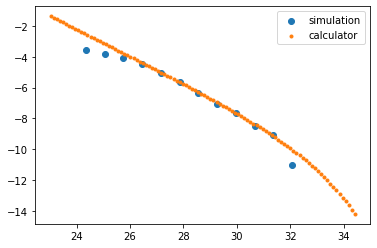

In [5]:
plt.scatter(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), label='simulation')
plt.scatter(np.log(dataset_calc['log_10(mvir)']), np.log(dataset_calc['n(>M)']), label='calculator', marker='.')
plt.legend()

## Creating a method to generate a neural network model with keras.

In [6]:
def ann_model(ninput=1, n_nodes1=100, n_nodes2=100, n_nodes3=100, dropout=0.5):
    model = models.Sequential()
    model.add(layers.Dense(n_nodes1,activation='relu',input_shape=(ninput,)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_nodes2,activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_nodes3,activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
#                   SGD(learning_rate=1e-4),#RMSprop(lr=0.001),
                        loss='mse',
                        metrics=['mse'])
    return model

# 1. Training a neural net with the data from calculator (dataset)

Using the log of the full dataset

In [7]:
dataset = np.log(dataset_calc)

In [8]:
np.max(dataset), np.min(dataset)

/home/isidro/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/isidro/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


(log_10(mvir)    34.423647
 n(>M)           -1.368933
 dtype: float64,
 log_10(mvir)    23.025851
 n(>M)          -14.188168
 dtype: float64)

Standarization of the data

In [9]:
X = dataset.values[:, 0]
Y = dataset.values[:, 1]

xscaler = StandardScaler()
yscaler = StandardScaler()
# # fit scaler on data
xscaler.fit(X.reshape(-1, 1))
yscaler.fit(Y.reshape(-1, 1))
# # apply transform
X_sc = xscaler.transform(X.reshape(-1, 1))
Y_sc = yscaler.transform(Y.reshape(-1, 1))

Split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_sc, Y_sc, test_size=0.1, random_state=42)

Generating a neural model for data from calculator:

In [11]:
neural_model_1 = ann_model(n_nodes1=100, n_nodes2=100, n_nodes3=100, dropout=0.5)

neural_model_1_history = neural_model_1.fit(X_train, y_train, epochs=500, batch_size=32, 
                                            validation_data=(X_val,y_val))

Epoch 1/500


2023-02-02 19:52:56.275290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 19:52:56.275480: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-02 19:52:56.275533: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-02 19:52:56.275577: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-02 19:52:56.275618: W tensorflow/c

3/3 [==============================] - 1s 54ms/step - loss: 1.0739 - mse: 1.0739 - val_loss: 0.7768 - val_mse: 0.7768
Epoch 2/500
3/3 [==============================] - 0s 9ms/step - loss: 1.0418 - mse: 1.0418 - val_loss: 0.7620 - val_mse: 0.7620
Epoch 3/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9725 - mse: 0.9725 - val_loss: 0.7475 - val_mse: 0.7475
Epoch 4/500
3/3 [==============================] - 0s 10ms/step - loss: 1.0540 - mse: 1.0540 - val_loss: 0.7335 - val_mse: 0.7335
Epoch 5/500
3/3 [==============================] - 0s 9ms/step - loss: 1.0019 - mse: 1.0019 - val_loss: 0.7193 - val_mse: 0.7193
Epoch 6/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8819 - mse: 0.8819 - val_loss: 0.7052 - val_mse: 0.7052
Epoch 7/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9515 - mse: 0.9515 - val_loss: 0.6911 - val_mse: 0.6911
Epoch 8/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9103 - mse: 0.9103 - val_loss: 0.

3/3 [==============================] - 0s 10ms/step - loss: 0.3458 - mse: 0.3458 - val_loss: 0.0676 - val_mse: 0.0676
Epoch 65/500
3/3 [==============================] - 0s 10ms/step - loss: 0.2821 - mse: 0.2821 - val_loss: 0.0628 - val_mse: 0.0628
Epoch 66/500
3/3 [==============================] - 0s 9ms/step - loss: 0.3725 - mse: 0.3725 - val_loss: 0.0582 - val_mse: 0.0582
Epoch 67/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2769 - mse: 0.2769 - val_loss: 0.0537 - val_mse: 0.0537
Epoch 68/500
3/3 [==============================] - 0s 9ms/step - loss: 0.3144 - mse: 0.3144 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 69/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2699 - mse: 0.2699 - val_loss: 0.0458 - val_mse: 0.0458
Epoch 70/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2118 - mse: 0.2118 - val_loss: 0.0421 - val_mse: 0.0421
Epoch 71/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2581 - mse: 0.2581 - val_lo

Epoch 127/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2492 - mse: 0.2492 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 128/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1596 - mse: 0.1596 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 129/500
3/3 [==============================] - 0s 11ms/step - loss: 0.1324 - mse: 0.1324 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 130/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1755 - mse: 0.1755 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 131/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1761 - mse: 0.1761 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 132/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1883 - mse: 0.1883 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 133/500
3/3 [==============================] - 0s 10ms/step - loss: 0.2114 - mse: 0.2114 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 134/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2367 -

3/3 [==============================] - 0s 9ms/step - loss: 0.1894 - mse: 0.1894 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 190/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1917 - mse: 0.1917 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 191/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1904 - mse: 0.1904 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 192/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2074 - mse: 0.2074 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 193/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1678 - mse: 0.1678 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 194/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1438 - mse: 0.1438 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 195/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1591 - mse: 0.1591 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 196/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1585 - mse: 0.1585 - v

3/3 [==============================] - 0s 9ms/step - loss: 0.1352 - mse: 0.1352 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 252/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1565 - mse: 0.1565 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 253/500
3/3 [==============================] - 0s 12ms/step - loss: 0.1632 - mse: 0.1632 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 254/500
3/3 [==============================] - 0s 11ms/step - loss: 0.1438 - mse: 0.1438 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 255/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1568 - mse: 0.1568 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 256/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1402 - mse: 0.1402 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 257/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1370 - mse: 0.1370 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 258/500
3/3 [==============================] - 0s 11ms/step - loss: 0.1381 - mse: 0.138

3/3 [==============================] - 0s 12ms/step - loss: 0.1102 - mse: 0.1102 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 314/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1312 - mse: 0.1312 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 315/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1367 - mse: 0.1367 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 316/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1400 - mse: 0.1400 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 317/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1052 - mse: 0.1052 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 318/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1444 - mse: 0.1444 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 319/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1157 - mse: 0.1157 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 320/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1370 - mse: 0.1370 

3/3 [==============================] - 0s 9ms/step - loss: 0.1408 - mse: 0.1408 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 376/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1239 - mse: 0.1239 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 377/500
3/3 [==============================] - 0s 14ms/step - loss: 0.1203 - mse: 0.1203 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 378/500
3/3 [==============================] - 0s 13ms/step - loss: 0.1550 - mse: 0.1550 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 379/500
3/3 [==============================] - 0s 12ms/step - loss: 0.1031 - mse: 0.1031 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 380/500
3/3 [==============================] - 0s 12ms/step - loss: 0.1274 - mse: 0.1274 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 381/500
3/3 [==============================] - 0s 13ms/step - loss: 0.1200 - mse: 0.1200 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 382/500
3/3 [==============================] - 0s 11ms/step - loss: 0.1533 - mse: 0.1

3/3 [==============================] - 0s 10ms/step - loss: 0.1295 - mse: 0.1295 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 438/500
3/3 [==============================] - 0s 11ms/step - loss: 0.1371 - mse: 0.1371 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 439/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1021 - mse: 0.1021 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 440/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1206 - mse: 0.1206 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 441/500
3/3 [==============================] - 0s 12ms/step - loss: 0.1240 - mse: 0.1240 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 442/500
3/3 [==============================] - 0s 10ms/step - loss: 0.0934 - mse: 0.0934 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 443/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1385 - mse: 0.1385 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 444/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0979 - mse: 0.09

3/3 [==============================] - 0s 10ms/step - loss: 0.1561 - mse: 0.1561 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 500/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1325 - mse: 0.1325 - val_loss: 0.0051 - val_mse: 0.0051


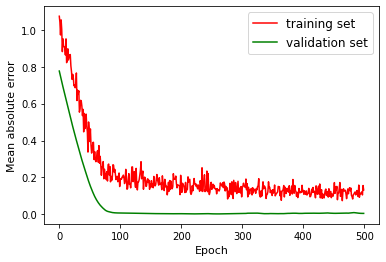

In [12]:
plt.plot(neural_model_1_history.history['mse'], color='r', )
plt.plot(neural_model_1_history.history['val_mse'], color='g')


plt.ylabel('Mean absolute error', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)

In [13]:
X_val = np.log(10**lcdm['log_10(M200c)'].values)
X_val_sc = xscaler.transform(X_val.reshape(-1,1))
ypred_sc = neural_model_1.predict(X_val_sc)
ypred = yscaler.inverse_transform(ypred_sc.reshape(-1,1))
#####
print('Traning and Testing on raw data, all features \n');

1/1 [==============================] - 0s 54ms/step
Traning and Testing on raw data, all features 



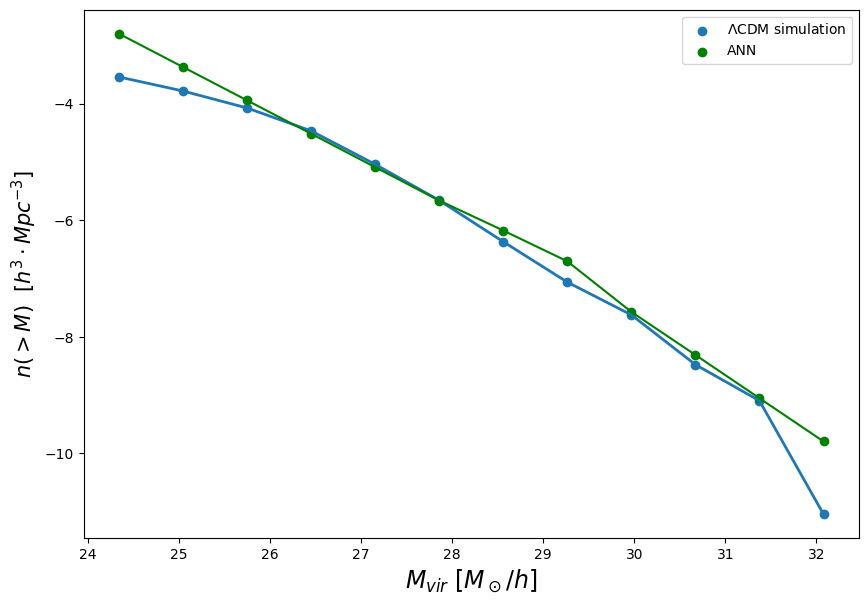

In [14]:
plt.figure(figsize=(10, 7), dpi=100)

# plt.yscale('log')
# plt.xscale('log')

plt.plot(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), linewidth=2)
plt.scatter(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), label='$\Lambda$CDM simulation')

plt.scatter(X_val, ypred, c='green', label='ANN')
plt.plot(X_val, ypred, c='green')


plt.xlabel('$M_{vir}$ $[M_\odot/h]$',fontsize=17)
plt.ylabel('$n(>M)$  $[h^3 \cdot Mpc^{-3}]$',fontsize=15)

# plt.xlim([3.e10,2.e14])
# plt.ylim([1.e-6,1.e-1])
plt.legend()
plt.savefig('HMF_SFDM_extended.png')
plt.show()

# 2. Using the simulation data for training an ANN model.

Using log for the full dataset

In [15]:
data_sim = lcdm.values
# plt.scatter(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), label='simulation')


In [16]:
X_sim = np.log(10**data_sim[:, 0])
Y_sim = np.log(data_sim[:, 2])

xsim_scaler = StandardScaler()
ysim_scaler = StandardScaler()
# # fit scaler on data
xsim_scaler.fit(X_sim.reshape(-1, 1))
ysim_scaler.fit(Y_sim.reshape(-1, 1))
# # apply transform
X_sim_sc = xsim_scaler.transform(X_sim.reshape(-1, 1))
Y_sim_sc = ysim_scaler.transform(Y_sim.reshape(-1, 1))

In [17]:
Xsim_train, Xsim_val, ysim_train, ysim_val = train_test_split(X_sim_sc, Y_sim_sc, test_size=0.1, random_state=42)

In [18]:
neural_model_2 = ann_model(n_nodes1=100, n_nodes2=100, n_nodes3=100, dropout=0.5)

neural_model_2_history = neural_model_2.fit(Xsim_train, ysim_train, epochs=500, batch_size=1, 
                                            validation_data=(Xsim_val,ysim_val))

Epoch 1/500
10/10 [==============================] - 1s 10ms/step - loss: 0.8564 - mse: 0.8564 - val_loss: 1.1254 - val_mse: 1.1254
Epoch 2/500
10/10 [==============================] - 0s 2ms/step - loss: 0.9157 - mse: 0.9157 - val_loss: 1.1191 - val_mse: 1.1191
Epoch 3/500
10/10 [==============================] - 0s 2ms/step - loss: 1.0648 - mse: 1.0648 - val_loss: 1.1168 - val_mse: 1.1168
Epoch 4/500
10/10 [==============================] - 0s 3ms/step - loss: 0.9792 - mse: 0.9792 - val_loss: 1.1120 - val_mse: 1.1120
Epoch 5/500
10/10 [==============================] - 0s 2ms/step - loss: 0.8753 - mse: 0.8753 - val_loss: 1.1045 - val_mse: 1.1045
Epoch 6/500
10/10 [==============================] - 0s 3ms/step - loss: 1.0647 - mse: 1.0647 - val_loss: 1.1014 - val_mse: 1.1014
Epoch 7/500
10/10 [==============================] - 0s 3ms/step - loss: 0.9718 - mse: 0.9718 - val_loss: 1.0978 - val_mse: 1.0978
Epoch 8/500
10/10 [==============================] - 0s 3ms/step - loss: 0.8156 - 

10/10 [==============================] - 0s 3ms/step - loss: 0.4680 - mse: 0.4680 - val_loss: 0.6327 - val_mse: 0.6327
Epoch 64/500
10/10 [==============================] - 0s 2ms/step - loss: 0.4556 - mse: 0.4556 - val_loss: 0.6225 - val_mse: 0.6225
Epoch 65/500
10/10 [==============================] - 0s 2ms/step - loss: 0.6778 - mse: 0.6778 - val_loss: 0.6116 - val_mse: 0.6116
Epoch 66/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3559 - mse: 0.3559 - val_loss: 0.6029 - val_mse: 0.6029
Epoch 67/500
10/10 [==============================] - 0s 2ms/step - loss: 0.5531 - mse: 0.5531 - val_loss: 0.5945 - val_mse: 0.5945
Epoch 68/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2285 - mse: 0.2285 - val_loss: 0.5853 - val_mse: 0.5853
Epoch 69/500
10/10 [==============================] - 0s 3ms/step - loss: 0.4970 - mse: 0.4970 - val_loss: 0.5691 - val_mse: 0.5691
Epoch 70/500
10/10 [==============================] - 0s 2ms/step - loss: 0.4296 - mse: 0

Epoch 125/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2040 - mse: 0.2040 - val_loss: 0.0926 - val_mse: 0.0926
Epoch 126/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2912 - mse: 0.2912 - val_loss: 0.0848 - val_mse: 0.0848
Epoch 127/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3846 - mse: 0.3846 - val_loss: 0.0791 - val_mse: 0.0791
Epoch 128/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2174 - mse: 0.2174 - val_loss: 0.0735 - val_mse: 0.0735
Epoch 129/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2045 - mse: 0.2045 - val_loss: 0.0697 - val_mse: 0.0697
Epoch 130/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3452 - mse: 0.3452 - val_loss: 0.0666 - val_mse: 0.0666
Epoch 131/500
10/10 [==============================] - 0s 3ms/step - loss: 0.4762 - mse: 0.4762 - val_loss: 0.0639 - val_mse: 0.0639
Epoch 132/500
10/10 [==============================] - 0s 2ms/step - 

10/10 [==============================] - 0s 2ms/step - loss: 0.1769 - mse: 0.1769 - val_loss: 4.8464e-04 - val_mse: 4.8464e-04
Epoch 187/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2267 - mse: 0.2267 - val_loss: 7.3274e-04 - val_mse: 7.3274e-04
Epoch 188/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0920 - mse: 0.0920 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 189/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2568 - mse: 0.2568 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 190/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2698 - mse: 0.2698 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 191/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0995 - mse: 0.0995 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 192/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3821 - mse: 0.3821 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 193/500
10/10 [==============================] - 0s 3ms/step 

10/10 [==============================] - 0s 2ms/step - loss: 0.1756 - mse: 0.1756 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 248/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3145 - mse: 0.3145 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 249/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0550 - mse: 0.0550 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 250/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3471 - mse: 0.3471 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 251/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0867 - mse: 0.0867 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 252/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1994 - mse: 0.1994 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 253/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1105 - mse: 0.1105 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 254/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3735 -

Epoch 309/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2200 - mse: 0.2200 - val_loss: 0.0160 - val_mse: 0.0160
Epoch 310/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0537 - mse: 0.0537 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 311/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1526 - mse: 0.1526 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 312/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3425 - mse: 0.3425 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 313/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0710 - mse: 0.0710 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 314/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1931 - mse: 0.1931 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 315/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0983 - mse: 0.0983 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 316/500
10/10 [==============================] - 0s 3ms/step - 

10/10 [==============================] - 0s 3ms/step - loss: 0.1716 - mse: 0.1716 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 371/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0779 - mse: 0.0779 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 372/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0809 - mse: 0.0809 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 373/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1412 - mse: 0.1412 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 374/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1492 - mse: 0.1492 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 375/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2591 - mse: 0.2591 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 376/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1295 - mse: 0.1295 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 377/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0820 -

10/10 [==============================] - 0s 3ms/step - loss: 0.0896 - mse: 0.0896 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 432/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0405 - mse: 0.0405 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 433/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2231 - mse: 0.2231 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 434/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2229 - mse: 0.2229 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 435/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1182 - mse: 0.1182 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 436/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0625 - mse: 0.0625 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 437/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2036 - mse: 0.2036 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 438/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0696 -

Epoch 493/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0516 - mse: 0.0516 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 494/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0375 - mse: 0.0375 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 495/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2494 - mse: 0.2494 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 496/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0893 - mse: 0.0893 - val_loss: 0.0168 - val_mse: 0.0168
Epoch 497/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1934 - mse: 0.1934 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 498/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 499/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1478 - mse: 0.1478 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 500/500
10/10 [==============================] - 0s 3ms/step - 

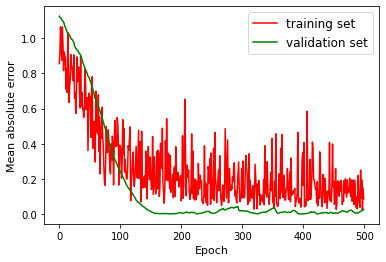

In [19]:
plt.plot(neural_model_2_history.history['mse'], color='r', )
plt.plot(neural_model_2_history.history['val_mse'], color='g')

plt.ylabel('Mean absolute error', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)

In [20]:
X_val2 = np.linspace(np.min(X_sim), np.max(X_sim), num=30)
X_val2_sc = xsim_scaler.transform(X_val2.reshape(-1,1))
ypred2_sc = neural_model_2.predict(X_val2_sc)
ypred2 = ysim_scaler.inverse_transform(ypred2_sc.reshape(-1,1))
#####
print('Traning and Testing on raw data, all features \n');

1/1 [==============================] - 0s 37ms/step
Traning and Testing on raw data, all features 



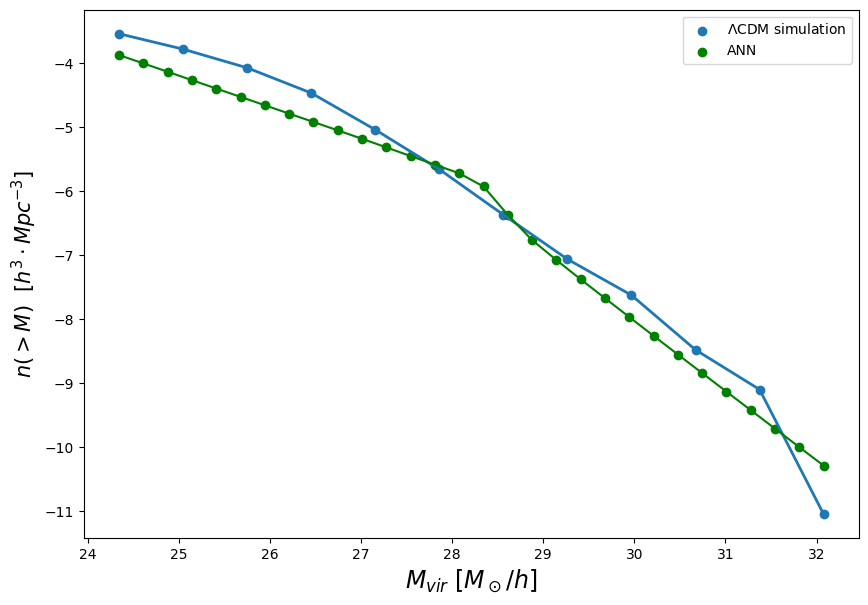

In [21]:
plt.figure(figsize=(10, 7), dpi=100)

plt.plot(X_sim, Y_sim, linewidth=2)
plt.scatter(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), label='$\Lambda$CDM simulation')

plt.scatter(X_val2, ypred2, c='green', label='ANN')
plt.plot(X_val2, ypred2, c='green')


plt.xlabel('$M_{vir}$ $[M_\odot/h]$',fontsize=17)
plt.ylabel('$n(>M)$  $[h^3 \cdot Mpc^{-3}]$',fontsize=15)

# plt.xlim([3.e10,2.e14])
# plt.ylim([1.e-6,1.e-1])
plt.legend()
plt.savefig('HMF_sim_vs_ANN.png')
plt.show()

It is ok, but because it is a very small dataset the ANN does not learn the extremes values. So, following  	arXiv:2104.00595 (or https://github.com/igomezv/neuralCosmoReconstruction/blob/master/notebooks/ANN%20Hz.ipynb), we force to consider them:

In [22]:
data_sim = lcdm.values
shuffle = [x for x in range(len(data_sim)) if x%2 == 0]
comp = [x for x in range(len(data_sim)) if x%2 == 1]
comp.extend(shuffle)
data_sim = data_sim[comp]

In [23]:
lcdm.values == data_sim

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [24]:
data_sim

array([[1.08775617e+01, 7.17000000e+02, 2.27040000e-02],
       [1.14882933e+01, 6.25000000e+02, 1.14560000e-02],
       [1.20990249e+01, 2.21000000e+02, 3.48000000e-03],
       [1.27097565e+01, 4.60000000e+01, 8.56000000e-04],
       [1.33204881e+01, 1.20000000e+01, 2.08000000e-04],
       [1.39312197e+01, 2.00000000e+00, 1.60000000e-05],
       [1.05721959e+01, 7.73000000e+02, 2.88880000e-02],
       [1.11829275e+01, 6.89000000e+02, 1.69680000e-02],
       [1.17936591e+01, 3.72000000e+02, 6.45600000e-03],
       [1.24043907e+01, 1.07000000e+02, 1.71200000e-03],
       [1.30151223e+01, 3.50000000e+01, 4.88000000e-04],
       [1.36258539e+01, 1.20000000e+01, 1.12000000e-04]])

In [25]:
X_sim = np.log(10**data_sim[:, 0])
Y_sim = np.log(data_sim[:, 2])

xsim_scaler = StandardScaler()
ysim_scaler = StandardScaler()
# # fit scaler on data
xsim_scaler.fit(X_sim.reshape(-1, 1))
ysim_scaler.fit(Y_sim.reshape(-1, 1))
# # apply transform
X_sim_sc = xsim_scaler.transform(X_sim.reshape(-1, 1))
Y_sim_sc = ysim_scaler.transform(Y_sim.reshape(-1, 1))

In [26]:
# Xsim_train, Xsim_val, ysim_train, ysim_val = train_test_split(X_sim_sc, Y_sim_sc, test_size=0.1, shuffle=None)

In [27]:
split = 0.9
ntrain = int(split * len(X_sim_sc))
indx = [ntrain]
Xsim_train, Xsim_val = np.split(X_sim_sc, indx)
ysim_train, ysim_val = np.split(Y_sim_sc, indx)



In [28]:
neural_model_2 = ann_model(n_nodes1=100, n_nodes2=100, n_nodes3=100, dropout=0.2)

neural_model_2_history = neural_model_2.fit(Xsim_train, ysim_train, epochs=500, batch_size=1, 
                                            validation_data=(Xsim_val,ysim_val))

Epoch 1/500
10/10 [==============================] - 1s 10ms/step - loss: 0.9338 - mse: 0.9338 - val_loss: 0.8455 - val_mse: 0.8455
Epoch 2/500
10/10 [==============================] - 0s 3ms/step - loss: 1.0229 - mse: 1.0229 - val_loss: 0.8180 - val_mse: 0.8180
Epoch 3/500
10/10 [==============================] - 0s 3ms/step - loss: 0.9869 - mse: 0.9869 - val_loss: 0.7985 - val_mse: 0.7985
Epoch 4/500
10/10 [==============================] - 0s 3ms/step - loss: 0.9000 - mse: 0.9000 - val_loss: 0.7801 - val_mse: 0.7801
Epoch 5/500
10/10 [==============================] - 0s 3ms/step - loss: 0.8968 - mse: 0.8968 - val_loss: 0.7585 - val_mse: 0.7585
Epoch 6/500
10/10 [==============================] - 0s 3ms/step - loss: 0.8751 - mse: 0.8751 - val_loss: 0.7305 - val_mse: 0.7305
Epoch 7/500
10/10 [==============================] - 0s 3ms/step - loss: 0.9275 - mse: 0.9275 - val_loss: 0.7107 - val_mse: 0.7107
Epoch 8/500
10/10 [==============================] - 0s 3ms/step - loss: 0.7961 - 

10/10 [==============================] - 0s 2ms/step - loss: 0.0610 - mse: 0.0610 - val_loss: 0.0396 - val_mse: 0.0396
Epoch 64/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1098 - mse: 0.1098 - val_loss: 0.0406 - val_mse: 0.0406
Epoch 65/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0395 - mse: 0.0395 - val_loss: 0.0465 - val_mse: 0.0465
Epoch 66/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0808 - mse: 0.0808 - val_loss: 0.0505 - val_mse: 0.0505
Epoch 67/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0540 - val_mse: 0.0540
Epoch 68/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0577 - val_mse: 0.0577
Epoch 69/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0765 - mse: 0.0765 - val_loss: 0.0624 - val_mse: 0.0624
Epoch 70/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1170 - mse: 0

Epoch 125/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0411 - mse: 0.0411 - val_loss: 0.1015 - val_mse: 0.1015
Epoch 126/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0556 - mse: 0.0556 - val_loss: 0.0897 - val_mse: 0.0897
Epoch 127/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0892 - val_mse: 0.0892
Epoch 128/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0794 - val_mse: 0.0794
Epoch 129/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0764 - mse: 0.0764 - val_loss: 0.0776 - val_mse: 0.0776
Epoch 130/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0822 - val_mse: 0.0822
Epoch 131/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0181 - mse: 0.0181 - val_loss: 0.0844 - val_mse: 0.0844
Epoch 132/500
10/10 [==============================] - 0s 3ms/step - 

10/10 [==============================] - 0s 3ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.1506 - val_mse: 0.1506
Epoch 187/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.1552 - val_mse: 0.1552
Epoch 188/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.1612 - val_mse: 0.1612
Epoch 189/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0791 - mse: 0.0791 - val_loss: 0.1554 - val_mse: 0.1554
Epoch 190/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0333 - mse: 0.0333 - val_loss: 0.1474 - val_mse: 0.1474
Epoch 191/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0627 - mse: 0.0627 - val_loss: 0.1340 - val_mse: 0.1340
Epoch 192/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0439 - mse: 0.0439 - val_loss: 0.1206 - val_mse: 0.1206
Epoch 193/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0154 -

10/10 [==============================] - 0s 3ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0971 - val_mse: 0.0971
Epoch 248/500
10/10 [==============================] - 0s 2ms/step - loss: 0.1075 - mse: 0.1075 - val_loss: 0.1035 - val_mse: 0.1035
Epoch 249/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0683 - mse: 0.0683 - val_loss: 0.1044 - val_mse: 0.1044
Epoch 250/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0598 - mse: 0.0598 - val_loss: 0.0880 - val_mse: 0.0880
Epoch 251/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0508 - mse: 0.0508 - val_loss: 0.0711 - val_mse: 0.0711
Epoch 252/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0501 - val_mse: 0.0501
Epoch 253/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 254/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0271 -

Epoch 309/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0505 - val_mse: 0.0505
Epoch 310/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0429 - mse: 0.0429 - val_loss: 0.0384 - val_mse: 0.0384
Epoch 311/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 312/500
10/10 [==============================] - 0s 2ms/step - loss: 0.1045 - mse: 0.1045 - val_loss: 0.0466 - val_mse: 0.0466
Epoch 313/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0804 - mse: 0.0804 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 314/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0522 - mse: 0.0522 - val_loss: 0.0551 - val_mse: 0.0551
Epoch 315/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0708 - val_mse: 0.0708
Epoch 316/500
10/10 [==============================] - 0s 3ms/step - 

10/10 [==============================] - 0s 3ms/step - loss: 0.0264 - mse: 0.0264 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 371/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0500 - val_mse: 0.0500
Epoch 372/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0459 - mse: 0.0459 - val_loss: 0.0603 - val_mse: 0.0603
Epoch 373/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0258 - mse: 0.0258 - val_loss: 0.0705 - val_mse: 0.0705
Epoch 374/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 0.0816 - val_mse: 0.0816
Epoch 375/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0502 - mse: 0.0502 - val_loss: 0.1021 - val_mse: 0.1021
Epoch 376/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0813 - mse: 0.0813 - val_loss: 0.1184 - val_mse: 0.1184
Epoch 377/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0493 -

Epoch 432/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0825 - mse: 0.0825 - val_loss: 0.0566 - val_mse: 0.0566
Epoch 433/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0589 - val_mse: 0.0589
Epoch 434/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0374 - mse: 0.0374 - val_loss: 0.0580 - val_mse: 0.0580
Epoch 435/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0557 - mse: 0.0557 - val_loss: 0.0660 - val_mse: 0.0660
Epoch 436/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0602 - val_mse: 0.0602
Epoch 437/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0567 - val_mse: 0.0567
Epoch 438/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 0.0560 - val_mse: 0.0560
Epoch 439/500
10/10 [==============================] - 0s 3ms/step - 

10/10 [==============================] - 0s 3ms/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0519 - val_mse: 0.0519
Epoch 494/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0450 - val_mse: 0.0450
Epoch 495/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0417 - val_mse: 0.0417
Epoch 496/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0428 - val_mse: 0.0428
Epoch 497/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0570 - mse: 0.0570 - val_loss: 0.0543 - val_mse: 0.0543
Epoch 498/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0573 - val_mse: 0.0573
Epoch 499/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0588 - val_mse: 0.0588
Epoch 500/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0056 -

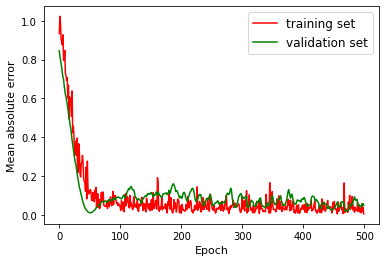

In [29]:
plt.plot(neural_model_2_history.history['mse'], color='r', )
plt.plot(neural_model_2_history.history['val_mse'], color='g')

plt.ylabel('Mean absolute error', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)

In [30]:
X_val2 = np.linspace(np.min(X_sim), np.max(X_sim), num=50)
X_val2_sc = xsim_scaler.transform(X_val2.reshape(-1,1))
ypred2_sc = neural_model_2.predict(X_val2_sc)
ypred2 = ysim_scaler.inverse_transform(ypred2_sc.reshape(-1,1))
#####
print('Traning and Testing on raw data, all features \n');

2/2 [==============================] - 0s 1ms/step
Traning and Testing on raw data, all features 



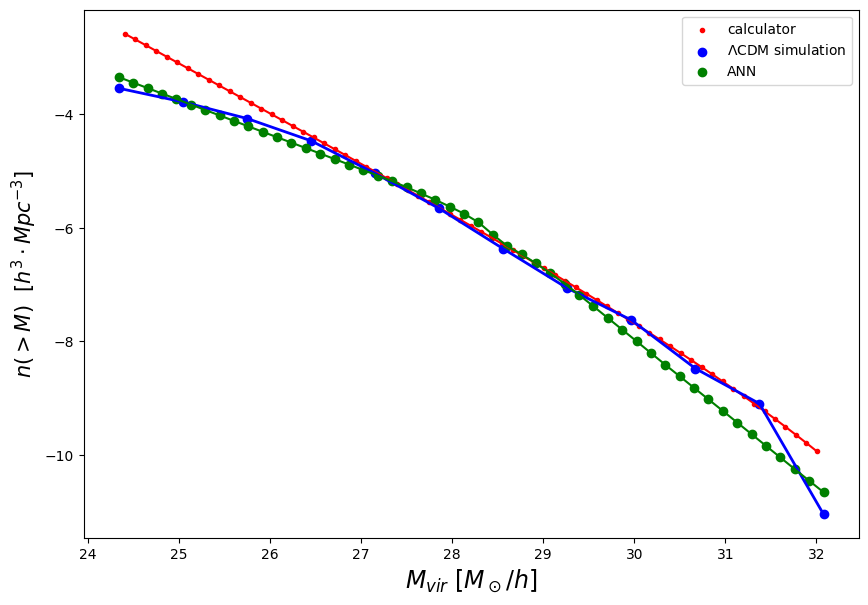

In [31]:
plt.figure(figsize=(10, 7), dpi=100)

# data from calculator
dataset_calc_x = np.log(dataset_calc['log_10(mvir)'])
dataset_calc_y = np.log(dataset_calc['n(>M)'])
boolArr = (dataset_calc_x >= np.min(X_val2)) & (dataset_calc_x <= np.max(X_val2))
dataset_calc_x = dataset_calc_x[boolArr]
dataset_calc_y = dataset_calc_y[boolArr]
plt.scatter(dataset_calc_x, dataset_calc_y, label='calculator', marker='.', c='red')
plt.plot(dataset_calc_x, dataset_calc_y, c='red')

# data from simulation
plt.plot(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), linewidth=2, c='blue')
plt.scatter(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), label='$\Lambda$CDM simulation', c='blue')

# data from ANN
plt.scatter(X_val2, ypred2, c='green', label='ANN')
plt.plot(X_val2, ypred2, c='green')

plt.xlabel('$M_{vir}$ $[M_\odot/h]$',fontsize=17)
plt.ylabel('$n(>M)$  $[h^3 \cdot Mpc^{-3}]$',fontsize=15)

plt.legend()
plt.savefig('HMF_sim_vs_ANN2.png')
plt.show()

# 3. Using Gaussian Process with data from simulation

References:
- https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html
- https://richardcsuwandi.medium.com/gaussian-process-regression-using-gpytorch-2c174286f9cc

In [65]:
import torch
import gpytorch

In [86]:
data_sim = lcdm.values
x_train = torch.tensor(np.log(10**data_sim[:, 0]))
y_train = torch.tensor(np.log(data_sim[:, 2]))

In [74]:
class SpectralMixtureGP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(SpectralMixtureGP, self).__init__(x_train, y_train, likelihood)
        self.mean = gpytorch.means.ConstantMean() # Construct the mean function
        self.cov = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4) # Construct the kernel function
        self.cov.initialize_from_data(x_train, y_train) # Initialize the hyperparameters from data
        
    def forward(self, x):
        # Evaluate the mean and kernel function at x
        mean_x = self.mean(x)
        cov_x = self.cov(x)
        # Return the multivariate normal distribution using the evaluated mean and kernel function
        return gpytorch.distributions.MultivariateNormal(mean_x, cov_x) 

In [87]:
# Initialize the likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGP(x_train, y_train, likelihood)

In [88]:
# Put the model into training mode
model.train()
likelihood.train()

# Use the Adam optimizer, with learning rate set to 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Use the negative marginal log-likelihood as the loss function
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Set the number of training iterations
n_iter = 50

for i in range(n_iter):
    # Set the gradients from previous iteration to zero
    optimizer.zero_grad()
    # Output from model
    output = model(X_sim)
    # Compute loss and backprop gradients
    loss = -mll(output, Y_sim)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 9.031
Iter 2/50 - Loss: 7.667
Iter 3/50 - Loss: 6.568
Iter 4/50 - Loss: 5.712
Iter 5/50 - Loss: 5.050
Iter 6/50 - Loss: 4.537
Iter 7/50 - Loss: 4.135
Iter 8/50 - Loss: 3.823
Iter 9/50 - Loss: 3.582
Iter 10/50 - Loss: 3.397
Iter 11/50 - Loss: 3.255
Iter 12/50 - Loss: 3.143
Iter 13/50 - Loss: 3.054
Iter 14/50 - Loss: 2.980
Iter 15/50 - Loss: 2.918
Iter 16/50 - Loss: 2.865
Iter 17/50 - Loss: 2.818
Iter 18/50 - Loss: 2.777
Iter 19/50 - Loss: 2.741
Iter 20/50 - Loss: 2.707
Iter 21/50 - Loss: 2.677
Iter 22/50 - Loss: 2.648
Iter 23/50 - Loss: 2.621
Iter 24/50 - Loss: 2.596
Iter 25/50 - Loss: 2.571
Iter 26/50 - Loss: 2.547
Iter 27/50 - Loss: 2.523
Iter 28/50 - Loss: 2.500
Iter 29/50 - Loss: 2.477
Iter 30/50 - Loss: 2.454
Iter 31/50 - Loss: 2.431
Iter 32/50 - Loss: 2.408
Iter 33/50 - Loss: 2.385
Iter 34/50 - Loss: 2.362
Iter 35/50 - Loss: 2.339
Iter 36/50 - Loss: 2.317
Iter 37/50 - Loss: 2.294
Iter 38/50 - Loss: 2.272
Iter 39/50 - Loss: 2.249
Iter 40/50 - Loss: 2.227
Iter 41/5

In [90]:
minrange = np.min(np.log(10**data_sim[:, 0]))
maxrange = np.max(np.log(10**data_sim[:, 0]))

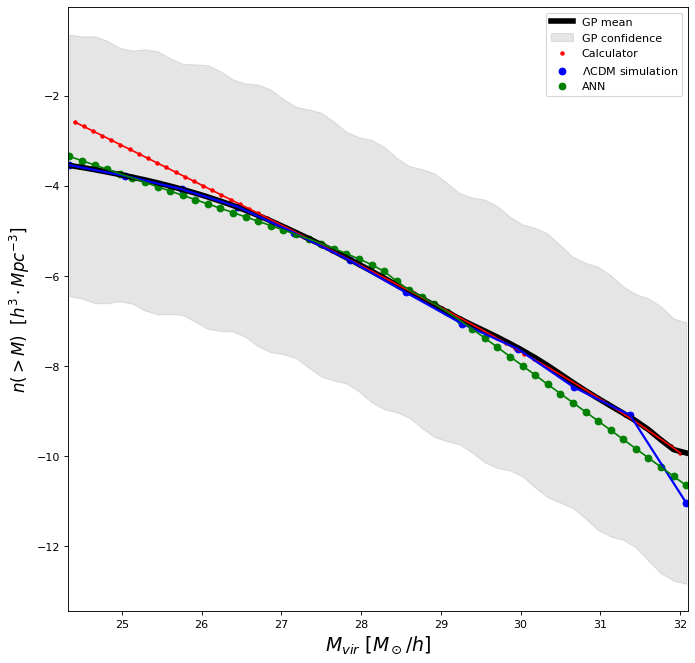

In [111]:
# The test data is 50 equally-spaced points
x_test = torch.linspace(minrange, maxrange, 50)
# Put the model into evaluation mode
model.eval()
likelihood.eval()
fig = plt.figure(figsize=(10, 10), dpi=80)

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Obtain the predictive mean and covariance matrix
    f_preds = model(x_test)
    f_mean = f_preds.mean
    f_cov = f_preds.covariance_matrix
    # Make predictions by feeding model through likelihood
    observed_pred = likelihood(model(x_test))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    plt.plot(x_test.numpy(), observed_pred.mean.numpy(), color='k', label='GP mean', linewidth=5)
    # Shade between the lower and upper confidence bounds
    plt.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, label='GP confidence', color='gray')
#     plt.legend(['Observed Data', 'Mean', 'Confidence'])

dataset_calc_x = np.log(dataset_calc['log_10(mvir)'])
dataset_calc_y = np.log(dataset_calc['n(>M)'])
boolArr = (dataset_calc_x >= np.min(X_val2)) & (dataset_calc_x <= np.max(X_val2))
dataset_calc_x = dataset_calc_x[boolArr]
dataset_calc_y = dataset_calc_y[boolArr]
plt.scatter(dataset_calc_x, dataset_calc_y, label='Calculator', marker='.', c='red')
plt.plot(dataset_calc_x, dataset_calc_y, c='red')

# data from simulation
plt.plot(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), linewidth=2, c='blue')
plt.scatter(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), label='$\Lambda$CDM simulation', c='blue')

# data from ANN
plt.scatter(X_val2, ypred2, c='green', label='ANN')
plt.plot(X_val2, ypred2, c='green')

plt.xlim(minrange-0.02, maxrange+0.02)
plt.xlabel('$M_{vir}$ $[M_\odot/h]$',fontsize=17)
plt.ylabel('$n(>M)$  $[h^3 \cdot Mpc^{-3}]$',fontsize=15)
plt.legend()
plt.savefig("ML_full.png")